In [1]:
import cv2
import mediapipe as mp
import tensorflow as tf
import time
import numpy as np
from sklearn.metrics import pairwise_distances
import utils
#import tflite_runtime.interpreter as tflite
import matplotlib.pyplot as plt
import math

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

2022-07-05 21:58:40.987037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /media/segate/Linux_programs/PythonVenv/.virtualenvs/env1/lib/python3.10/site-packages/cv2/../../lib64::/usr/local/lib:/usr/lib/x86_64-linux-gnu
2022-07-05 21:58:40.987056: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [291]:
image_path = './videos/tree.gif'

image_path2 = './videos/tree4.gif'
cap1 = cv2.VideoCapture(image_path)
cap2 = cv2.VideoCapture(image_path2)

In [231]:
def get_pose_coord(landmarks1, landmarks2):
    pose1= []
    pose2= []
    for idx, landmark in enumerate(landmarks1):
        x = landmark.x
        y = landmark.y
        z = landmark.z
        pose1.append((x,y,z))

    for idx, landmark in enumerate(landmarks2):
        x = landmark.x
        y = landmark.y
        z = landmark.z
        pose2.append((x,y,z))
    
    return (pose1, pose2)


    

In [232]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

In [233]:
def compute_similarity(pose_1, pose_2):
    p1 = []
    p2 = []

    for joint in range(pose_1.shape[0]):
        x1 = pose_1[joint][0]
        y1 = pose_1[joint][1]
        z1 = pose_1[joint][2]
        x2 = pose_2[joint][0]
        y2 = pose_2[joint][1]
        z2 = pose_2[joint][2]

        p1.append(x1)
        p1.append(y1)
        p1.append(z1)
        p2.append(x2)
        p2.append(y2)
        p2.append(z2)

    p1 = np.array(p1,dtype=float)
    p2 = np.array(p2,dtype=float)
    x = [p1,p2]
    euclid = pairwise_distances(x)[0][1]
    cosine = pairwise_distances(x, metric = 'cosine')[0][1]
    
    p1_cos = p1*1000
    p2_cos = p2*1000

    return ("Cosine:",cosine_similarity(p1_cos,p2_cos),"Euclidian:",euclid,"Chebyshev:", pairwise_distances(x, metric='chebyshev')[0][1])
    #return pairwise_distances(x, metric='correlation') 
    


In [234]:
def get_model_prediction(results1, results2):
  pose1, pose2 = get_pose_coord(results1.pose_landmarks.landmark, results2.pose_landmarks.landmark)
  pose1 = np.array(pose1)
  pose2 = np.array(pose2)

  point = results1.pose_world_landmarks.landmark
  lists1 = [[point[val].x, point[val].y, point[val].z, point[val].visibility] for val in mp_holistic.PoseLandmark]

  point = results2.pose_world_landmarks.landmark
  lists2 = [[point[val].x, point[val].y, point[val].z, point[val].visibility] for val in mp_holistic.PoseLandmark]

  inp = np.concatenate([lists1, lists2]).flatten().reshape(1, 264)
  pred = model.predict(inp)
  return pred[0][0]

In [235]:
def calculateAngle(landmark1, landmark2, landmark3):

    x1, y1= landmark1[0], landmark1[1]
    x2, y2 = landmark2[0], landmark2[1]
    x3, y3 = landmark3[0], landmark3[1]

    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))    
    
    # if angle < 0:

    
    #     angle += 360
    
    return abs(angle)

In [236]:
def get_angles(landmarks):

    left_elbow_angle = calculateAngle(landmarks[11],
                                      landmarks[13],
                                      landmarks[15])
    
    # Get the angle between the right shoulder, elbow and wrist points. 
    right_elbow_angle = calculateAngle(landmarks[12],
                                       landmarks[14],
                                       landmarks[16])   
    
    # Get the angle between the left elbow, shoulder and hip points. 
    left_shoulder_angle = calculateAngle(landmarks[13],
                                         landmarks[11],
                                         landmarks[23])

    # Get the angle between the right hip, shoulder and elbow points. 
    right_shoulder_angle = calculateAngle(landmarks[24],
                                          landmarks[12],
                                          landmarks[14])

    # Get the angle between the left hip, knee and ankle points. 
    left_knee_angle = calculateAngle(landmarks[23],
                                     landmarks[25],
                                     landmarks[27])

    # Get the angle between the right hip, knee and ankle points 
    right_knee_angle = calculateAngle(landmarks[24],
                                      landmarks[26],
                                      landmarks[28])

    return [left_elbow_angle, right_elbow_angle, left_shoulder_angle, right_shoulder_angle, left_knee_angle, right_knee_angle]


In [238]:
def get_non_matching_joints(angles1, angles2):
  angles_diff = np.array(angles1) - np.array(angles2)
  names = ['left_elbow', 'right_elbow', 'left_shoulder', 'right_shoulder', 'left_knee', 'right_knee']

  indexes = np.array([[(11,13), (13,15)], [(12,14), (14,16)], [(11,13), (11,23)], [(12,24), (12,14)], [(23,25), (25,27)], [(24,26), (26,28)]])

  names = np.array(names)
  out = [abs(x)/10 for x in angles_diff]

  bool_arr = [0 if x<=1 else 1 for x in out]

  wrong = []
  for idx, i in enumerate(bool_arr):
      if i==1:
          wrong.append(indexes[idx])
  
  return np.array(wrong).reshape(-1,2)

TFLITE Processing

In [244]:
interpreter1 =tf.lite.Interpreter(model_path='./models/pose_landmark_lite.tflite')
interpreter1.allocate_tensors()

interpreter2 =tf.lite.Interpreter(model_path='./models/pose_landmark_lite.tflite')
interpreter2.allocate_tensors()

In [245]:
def tflite_predict(frame):
    img = frame.copy()
    #img = tf.image.resize_with_pad(np.expand_dims(img, axis =0), 256,256)
    img= cv2.resize(img,dsize=(256,256), interpolation = cv2.INTER_CUBIC)
    img = np.expand_dims(img, axis =0)
    inp_img= tf.cast(img, dtype=tf.float32)

    input_details = interpreter1.get_input_details()
    output_details = interpreter1.get_output_details()

    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], np.array(inp_img))
    interpreter.invoke()

    keypoints = interpreter.get_tensor(output_details[0]['index'])

    return keypoints

In [267]:
def process(keypoints):
    arr = []
    for i in range(33):
        elt = keypoints.squeeze()[5*i:(5*i)+3]
        elt = np.append(elt, sigmoid(keypoints.squeeze()[(5*i)+3]))
        elt = np.append(elt, sigmoid(keypoints.squeeze()[(5*i)+4]))
        arr.append(elt)
    arr = np.array(arr)

    return arr

In [255]:
def visible(keypoints, visibility_threshold=0.5):
    idx_of_visible_points = []

    for idx, elt in enumerate(keypoints):
        if(elt[3]>visibility_threshold):
            idx_of_visible_points.append(idx)
    return idx_of_visible_points

In [ ]:
img = cv2.imread('./images/nadal1.jpg')
img2= cv2.resize(img,dsize=(256,256), interpolation = cv2.INTER_CUBIC)

keypoints2 = tflite_predict(img)
img_height, img_width, _ = img.shape
keypoints2 = process(keypoints2)
x,y,z,v,p =keypoints2.T
idx_of_visible_points = visible(keypoints, 0)
not_matching = get_non_matching_joints(get_angles(keypoints1), get_angles(keypoints2))

# draw_landmarks(img2,keypoints2, 0, not_matching)

# idx_of_visible_points = visible(keypoints2, 0)

# not_matching = get_non_matching_joints(get_angles(keypoints1), get_angles(keypoints2))

for i in connections:
    if i[0] in idx_of_visible_points and i[1] in idx_of_visible_points:
        point1 = ((x[i[0]]*img_width/256).astype('int'), (y[i[0]]*img_height/256).astype('int'))
        point2 = ((x[i[1]]*img_width/256).astype('int'), (y[i[1]]*img_height/256).astype('int'))
        if i in not_matching:
            cv2.line(img2, (x[i[0]].astype('int'),y[i[0]].astype('int')) ,(x[i[1]].astype('int'),y[i[1]].astype('int')) ,(255, 0, 0), 2)
            continue
        cv2.line(img2, (x[i[0]].astype('int'),y[i[0]].astype('int')) ,(x[i[1]].astype('int'),y[i[1]].astype('int')) ,(255, 0, 0), 2)


# x = x[::-1]
# y = y[::-1]

# for i in connections:
#     cv2.line(img2, point1,point2 , (0, 255, 0), 2)

plt.imshow(img2)
plt.show()

In [246]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [268]:
cap3 = cv2.VideoCapture(0)

for i in range(50):
    ret,frame = cap3.read()
    if ret:

        keypoints = tflite_predict(frame)
        img= cv2.resize(frame,dsize=(256,256), interpolation = cv2.INTER_CUBIC)

        keypoints = process(keypoints)

        x,y,z,v,p =keypoints.T

        idx_of_visible_points = visible(keypoints)

        draw_landmarks(frame, keypoints, 0.5)
            
        cv2.imshow("vid", frame)


        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap3.release()
cv2.destroyAllWindows()

In [275]:
def draw_landmarks(image, keypoints, visibility_threshold, wrong_joints = []):
    img_height, img_width, _ = image.shape
    idx_of_visible_points = visible(keypoints, visibility_threshold)

    connections = frozenset({(0, 1),(0, 4),(1, 2),(2, 3),(3, 7),(4, 5),(5, 6),(6, 8),(9, 10),(11, 12),(11, 13),(11, 23),(12, 14),(12, 24),(13, 15),(14, 16),(15, 17),(15, 19),(15, 21),(16, 18),(16, 20),(16, 22),(17, 19),(18, 20),(23, 24),(23, 25),(24, 26),(25, 27),(26, 28),(27, 29),(27, 31),(28, 30),(28, 32),(29, 31),(30, 32)})

    for i in connections:
        if i[0] in idx_of_visible_points and i[1] in idx_of_visible_points:
            point1 = ((x[i[0]]*img_width/256).astype('int'), (y[i[0]]*img_height/256).astype('int'))
            point2 = ((x[i[1]]*img_width/256).astype('int'), (y[i[1]]*img_height/256).astype('int'))
            if i in wrong_joints:
                cv2.line(image, point1,point2 , (255, 0, 0), 2)
                continue
            cv2.line(image, point1,point2 , (0, 255, 0), 2)
            
    

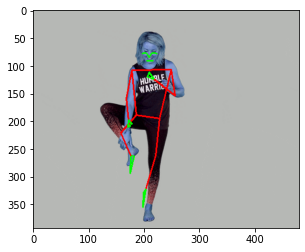

In [290]:
ret,frame2 = cap2.read()

keypoints2 = tflite_predict(frame2)
img_height, img_width, _ = frame2.shape
keypoints2 = process(keypoints2)
x,y,z,v,p =keypoints2.T

not_matching = get_non_matching_joints(get_angles(keypoints1), get_angles(keypoints2))

draw_landmarks(frame2,keypoints2, 0, not_matching)

# idx_of_visible_points = visible(keypoints2, 0)

# not_matching = get_non_matching_joints(get_angles(keypoints1), get_angles(keypoints2))

# for i in connections:
#     if i[0] in idx_of_visible_points and i[1] in idx_of_visible_points:
#         point1 = ((x[i[0]]*img_width/256).astype('int'), (y[i[0]]*img_height/256).astype('int'))
#         point2 = ((x[i[1]]*img_width/256).astype('int'), (y[i[1]]*img_height/256).astype('int'))
#         if i in not_matching:
#             cv2.line(frame2, point1,point2 , (255, 0, 0), 2)
#             continue
#         cv2.line(frame2, point1,point2 , (0, 255, 0), 2)


# x = x[::-1]
# y = y[::-1]

# for i in connections:
#     cv2.line(img2, point1,point2 , (0, 255, 0), 2)

cv2.imwrite('./' + '0' + '.png', frame2)

plt.imshow(frame2)
plt.show()

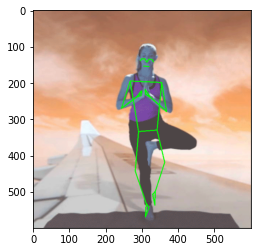

In [292]:
ret,frame1 = cap1.read()

keypoints1 = tflite_predict(frame1)
img_height, img_width, _ = frame2.shape
keypoints1 = process(keypoints1)
x,y,z,v,p =keypoints1.T
draw_landmarks(frame1, keypoints1, 0)

plt.imshow(frame1)
plt.show()
plt.show()